<a href="https://colab.research.google.com/github/Anam2291/Deep_Learning_Projects/blob/main/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [2]:
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# **Load Dataset**

In [3]:
# Install the Kaggle library
!pip install kaggle

# Set Kaggle API key
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Extract dataset
dataset_zip = 'intel-image-classification.zip'
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Dataset extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 97% 337M/346M [00:03<00:00, 144MB/s]
100% 346M/346M [00:03<00:00, 116MB/s]
Dataset extracted successfully!


# **Define Dataset Paths**

In [4]:
# Define directories
train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'


# **Explore the Dataset**

In [5]:
# View the categories
categories = os.listdir(train_dir)
print(f"Categories: {categories}")

Categories: ['street', 'sea', 'buildings', 'mountain', 'forest', 'glacier']


# **Display a few images from each category**


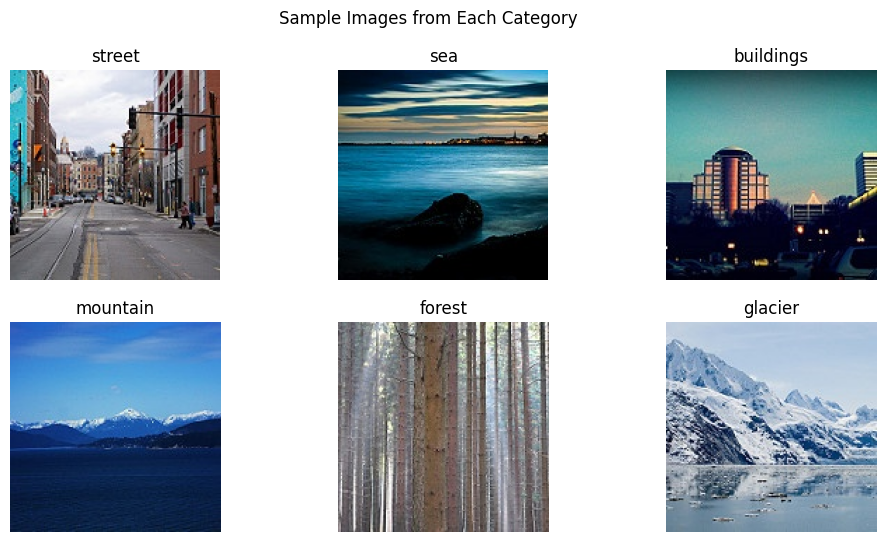

In [6]:
plt.figure(figsize=(12, 6))
for i, category in enumerate(categories[:6]):
    category_path = os.path.join(train_dir, category)
    image_name = os.listdir(category_path)[0]
    image_path = os.path.join(category_path, image_name)
    img = plt.imread(image_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(category)
    plt.axis('off')
plt.suptitle("Sample Images from Each Category")
plt.show()

# **Data Preprocessing**

**Data Augmentation and Preprocessing**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [8]:
# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# **Build the Model with VGG16**

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Unfreeze Some Layers of VGG16**

In [10]:
for layer in base_model.layers[:15]:  # Freeze the first 15 layers
    layer.trainable = False

for layer in base_model.layers[15:]:  # Unfreeze the last few layers
    layer.trainable = True


# **Compile the Model**

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a smaller learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 9,178,374 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# **Train the Model**

In [12]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs= 10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 132s 255ms/step - accuracy: 0.7197 - loss: 0.7460 - val_accuracy: 0.8830 - val_loss: 0.3207
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 114s 228ms/step - accuracy: 0.8880 - loss: 0.3345 - val_accuracy: 0.8867 - val_loss: 0.3084
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 98s 221ms/step - accuracy: 0.9060 - loss: 0.2705 - val_accuracy: 0.9173 - val_loss: 0.2393
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 99s 222ms/step - accuracy: 0.9163 - loss: 0.2397 - val_accuracy: 0.8787 - val_loss: 0.3338
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 223ms/step - accuracy: 0.9250 - loss: 0.2047 - val_accuracy: 0.9110 - val_loss: 0.2536
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 98s 220ms/step - accuracy: 0.9346 - loss: 0.1823 - val_accuracy: 0.9180 - val_loss: 0.2451
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 147s 232ms/step - accuracy: 0.9428 - loss: 0.1595 - val_accuracy: 0.9193 - val_loss: 0.2315
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 138s 225ms/step - accuracy: 0.9439 - loss: 0.1527 

# **Evaluate the Model**

In [13]:
# Step 8: Evaluate the Model
print("Evaluating the model...")

# Evaluate on the training data
train_loss, train_acc = model.evaluate(train_generator, verbose=0)

# Evaluate on the test (validation) data
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

# Print the evaluation results in a concise format
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")



Evaluating the model...
Training Loss: 0.0985, Training Accuracy: 96.36%
Test Loss: 0.3110, Test Accuracy: 91.33%


In [14]:
# Predict the test set and print additional details
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(labels, predicted_classes, target_names=class_labels))


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.93       437
      forest       0.98      1.00      0.99       474
     glacier       0.91      0.83      0.87       553
    mountain       0.88      0.83      0.85       525
         sea       0.87      0.97      0.92       510
      street       0.93      0.95      0.94       501

    accuracy                           0.91      3000
   macro avg       0.91      0.92      0.91      3000
weighted avg       0.91      0.91      0.91      3000



# **Plot Training History**

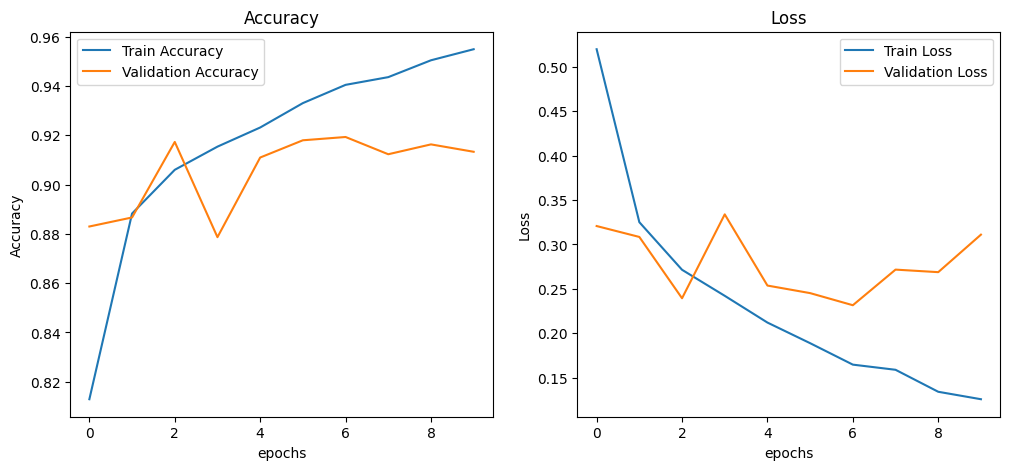

In [15]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.show()

# **Print classification report for detailed metrics**

In [16]:
print("Classification Report:")
print(classification_report(labels, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.92      0.93       437
      forest       0.98      1.00      0.99       474
     glacier       0.91      0.83      0.87       553
    mountain       0.88      0.83      0.85       525
         sea       0.87      0.97      0.92       510
      street       0.93      0.95      0.94       501

    accuracy                           0.91      3000
   macro avg       0.91      0.92      0.91      3000
weighted avg       0.91      0.91      0.91      3000



# **Compute the confusion matrix**

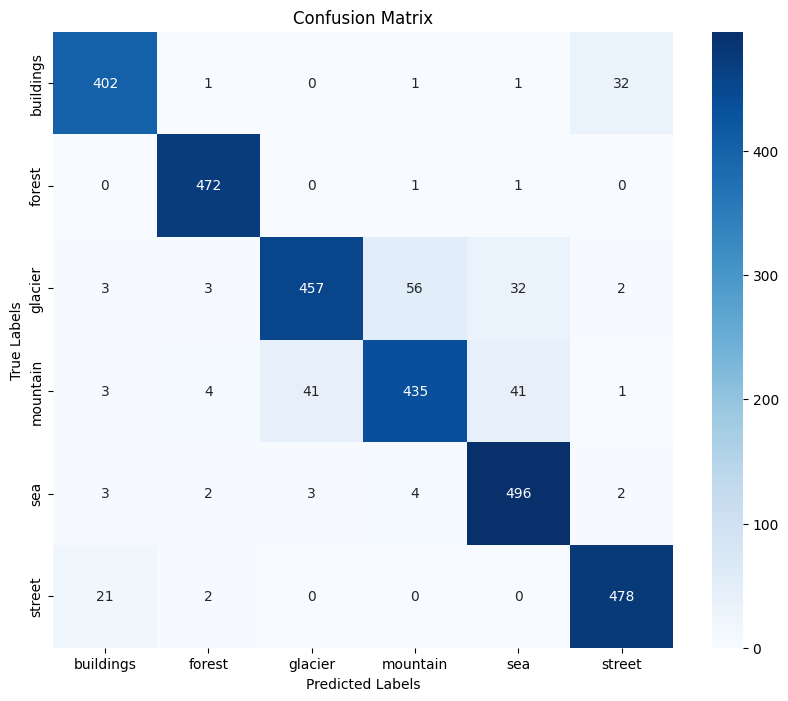

In [17]:
conf_matrix = confusion_matrix(labels, predicted_classes)

# Visualize the confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **Display Model Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


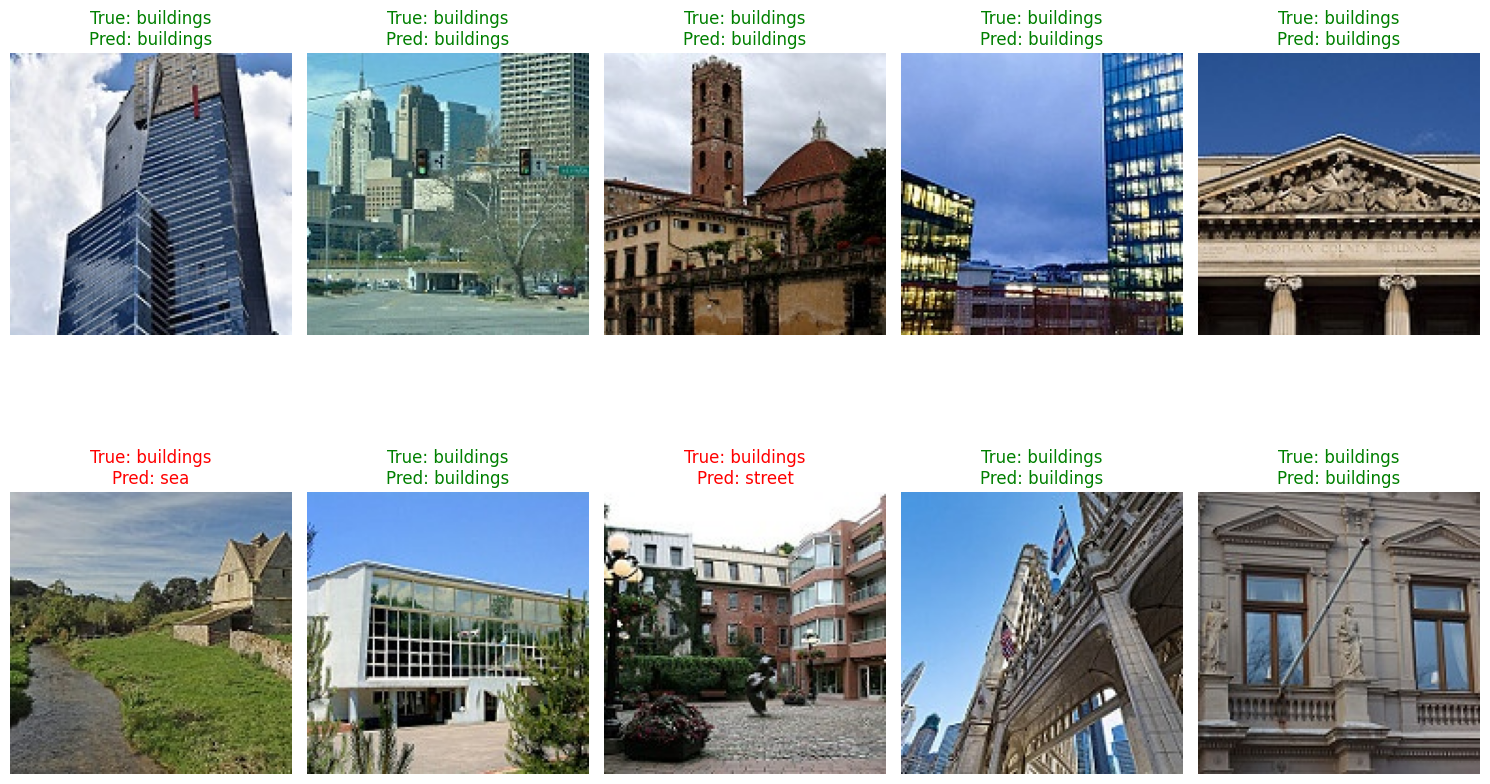

In [18]:
# Step 10: Display Model Predictions
def plot_predictions(model, generator, class_indices):
    class_labels = {v: k for k, v in class_indices.items()}
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    plt.figure(figsize=(15, 10))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        true_label = class_labels[true_classes[i]]
        pred_label = class_labels[predicted_classes[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", color='green' if true_label == pred_label else 'red')
    plt.tight_layout()
    plt.show()

plot_predictions(model, test_generator, test_generator.class_indices)